# Classification
### The Problem
We'll be working on the MNIST digit classification problem

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [2]:
#print(mnist["DESCR"])

In [3]:
import seaborn as sns
sns.set()

scikit has it's own format for these common datasets

In [4]:
print("it follows this structure: ", mnist.keys())

it follows this structure:  dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])


In [5]:
print("number of features: ", len(mnist["feature_names"]))
print("number of records: ", mnist.data.shape[0])

number of features:  784
number of records:  70000


the target is a number between 0 and 9

In [6]:
print(min(mnist["target"]), "to", max(mnist["target"]))

0 to 9


In [7]:
import numpy as np
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8) # convert y from string to int

In [8]:
print("Number of images: ", X.shape[0])

Number of images:  70000


we can visualize each image too

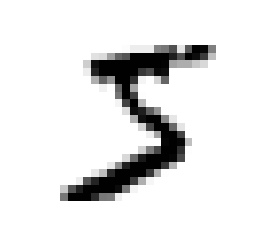

should look like a 5


In [9]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
i = 0

some_digit = X[i]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print("should look like a", y[i])

Let's split the data into train and test sets. It's pre shuffled so we don't have to randomly split

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

We can simplify the problem by converting it into a binary classiciation problem -- maybe only detect 5's?

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf_p = sgd_clf.predict(X_train)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_train_5, sgd_clf_p))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     54579
        True       0.92      0.66      0.77      5421

   micro avg       0.96      0.96      0.96     60000
   macro avg       0.94      0.83      0.87     60000
weighted avg       0.96      0.96      0.96     60000



In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9532
0.95125
0.9625


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9532 , 0.95125, 0.9625 ])

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
# row: actual class, column: predicted class
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[52992,  1587],
       [ 1074,  4347]])

Let's look at some other metrics that could be useful:
#### Precision
aka positive predictive value (PPV)
\begin{equation*}
\frac{TP}{TP+FP}
\end{equation*}
#### Recall 
aka sensitivity or true positive rate (TPR) -- the ratio of positive instances that are correctly detected by the classifier
\begin{equation*}
\frac{TP}{TP+FN}
\end{equation*}

How do we balance the two? Increasing precision, reduces recall, and vice versa -- this is the precision/recall tradeoff.

e.g. if you trained a classifier to detect if videos are safe for kids, then you'll want high precision and low recall -- i.e. rejects many good videos but keeps only safe ones

on the other hand suppose you train a classifier to detect shoplifters on surveillance images, it's probably fine to have 30% precision, if you have 99% recall

When looking at the confusion matrix, the column is the predicted value, and the rows are the actual values

In [19]:
tn = cm[0][0]
tp = cm[1][1]
fn = cm[1][0]
fp = cm[0][1]
print("precision:", tp * 1.0 / (tp + fp))
print("recall:", tp * 1.0 / (tp + fn))

precision: 0.7325581395348837
recall: 0.8018815716657444


In [20]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7325581395348837
0.8018815716657444


#### F Score
The harmonic mean of the precision and recall. 
\begin{equation*}
\frac{2}{\frac{1}{precision}+\frac{1}{recall}}
\end{equation*}

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.765653896961691

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-45148.19955869])

Deciding a threshold to use can be tricky. We can use the cross_val_predict function from earlier to help us

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

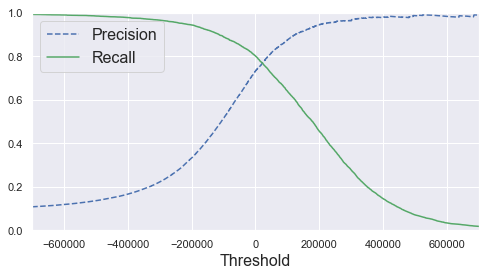

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

plt.savefig("precision_vs_recall.png")

what if we want a higher precision? 

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.5993359158826784

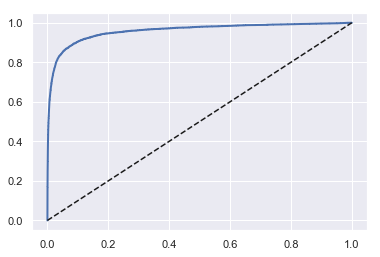

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9584692857783504

should we use PR curve or AUC curve? Well, that depends on the problem. If the positive class is rare, or if you care more about false positives, than false negatives, use the PR cruve

how would a random forest classifier perform? 

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

we can check the ROC curve

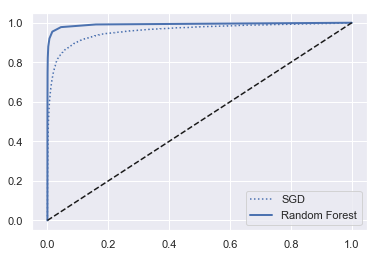

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

#### Multiclass Classification
Some classifiers can handle multiple classes (e.g. random forest, naive bayes), but other can't. Instead, the approach is to train as many models as there are classes in your response variable. 

In [36]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [37]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-433195.51807197, -338154.39320296, -233775.78280018,
         -96549.33208399, -775699.13613034,  -45148.19955869,
        -536304.97603686, -298210.05377635, -535633.57179217,
        -490653.60782097]])

In [38]:
np.argmax(some_digit_scores)

5

In [39]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

let's test the accuracy of the sgd model

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86872625, 0.87639382, 0.87848177])

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90736853, 0.90884544, 0.91363705])

### Error analysis

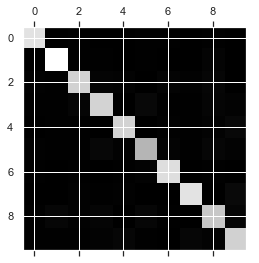

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

We can compare error rates instead of total errors, that way it's not dependant on the number of images in each class

In [44]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# by filling the diagonal, we can focus on the errors
np.fill_diagonal(norm_conf_mx, 0)

rows represent the actual classes, and the columns are predicitons

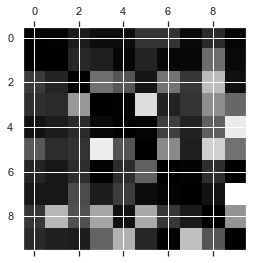

In [45]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray);

In [46]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

looking at individual examples that were wrong, we can see where the classifier misrepresented the 3's and 5's. The top right, and bottom left are both misclassifications

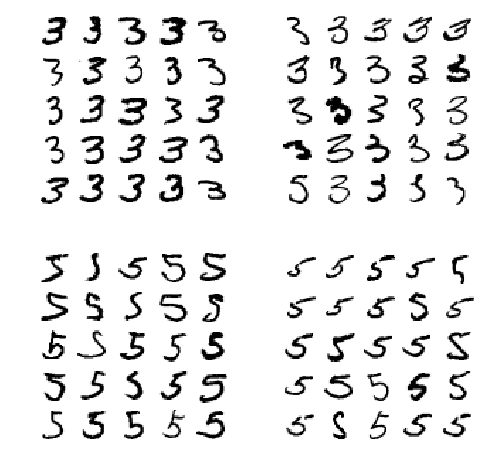

In [47]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multiclass classification

In [48]:
from sklearn.neighbors import KNeighborsClassifier # by default supports multilabel classification

y_train_large = (y_train >= 7)   # dummy label 1
y_train_odd = (y_train % 2 == 1) # dummy label 2
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')